# Import Libraries
Import necessary libraries such as pandas, numpy, scikit-learn, xgboost, lightgbm, etc.

In [23]:
# !pip install lightgbm

In [24]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical computations
from sklearn.model_selection import train_test_split  # For splitting data into train and test sets
from sklearn.ensemble import RandomForestClassifier  # For Random Forest model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # For model evaluation
import xgboost as xgb  # For XGBoost model
import lightgbm as lgb  # For LightGBM model
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For advanced data visualization
import joblib  # For saving models to local directory

# Set visualization style
sns.set(style="whitegrid")

# Load and Explore Data
Load the dataset from the local CSV file using pandas and explore its basic statistics and structure.

In [25]:
# Load the dataset from the local CSV file
data_path = "./Churn_Modelling.csv"  # Replace with the actual path to your dataset
df = pd.read_csv(data_path)

# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
print(df.head())

# Display basic information about the dataset
print("\nDataset Information:")
df.info()

# Display basic statistics of the dataset
print("\nBasic Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Display the shape of the dataset
print("\nDataset Shape:")
print(df.shape)

# Display the column names
print("\nColumn Names:")
print(df.columns.tolist())

First 5 rows of the dataset:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         938

# Data Preprocessing
Handle missing values, encode categorical features, and scale numerical features.

In [26]:
df.select_dtypes(include=["object"]).columns

Index(['Surname', 'Geography', 'Gender'], dtype='object')

In [27]:
# Handle missing values
# Fill missing numerical values with the median of each column
numerical_columns = df.select_dtypes(include=["float64", "int64"]).columns
numerical_columns = list(set(list(numerical_columns)) - set(['Exited'])) # Remove 'Exited' from numerical columns for correlation analysis

df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].median())

# Fill missing categorical values with the mode of each column
categorical_columns = df.select_dtypes(include=["object"]).columns
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

# Encode categorical features using one-hot encoding
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Scale numerical features using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Display the first few rows of the preprocessed dataset
print("\nFirst 5 rows of the preprocessed dataset:")
print(df.head())


First 5 rows of the preprocessed dataset:
   RowNumber  CustomerId  CreditScore       Age    Tenure   Balance  \
0  -1.731878   -0.783213    -0.326221  0.293517 -1.041760 -1.225848   
1  -1.731531   -0.606534    -0.440036  0.198164 -1.387538  0.117350   
2  -1.731185   -0.995885    -1.536794  0.293517  1.032908  1.333053   
3  -1.730838    0.144767     0.501521  0.007457 -1.387538 -1.225848   
4  -1.730492    0.652659     2.063884  0.388871 -1.041760  0.785728   

   NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  ...  \
0      -0.911583   0.646092        0.970243         0.021886  ...   
1      -0.911583  -1.547768        0.970243         0.216534  ...   
2       2.527057   0.646092       -1.030670         0.240687  ...   
3       0.807737  -1.547768       -1.030670        -0.108918  ...   
4      -0.911583   0.646092        0.970243        -0.365276  ...   

   Surname_Zotova  Surname_Zox  Surname_Zubarev  Surname_Zubareva  \
0               0            0                

# Feature Engineering
Create new features from existing ones to improve model performance.

In [28]:
# Create new features from existing ones to improve model performance

# Create a new feature: 'BalanceSalaryRatio' (Ratio of Balance to Estimated Salary)
df['BalanceSalaryRatio'] = df['Balance'] / (df['EstimatedSalary'] + 1e-5)  # Adding a small value to avoid division by zero

# Create a new feature: 'TenureByAge' (Ratio of Tenure to Age)
df['TenureByAge'] = df['Tenure'] / (df['Age'] -18 + 1e-5)  # Adding a small value to avoid division by zero

# Create a new feature: 'CreditScoreGivenAge' (Ratio of Credit Score to Age)
df['CreditScoreGivenAge'] = df['CreditScore'] / (df['Age'] -18 + 1e-5)  # Adding a small value to avoid division by zero

# Create a new feature: 'NumOfProductsAndHasCrCard' (Interaction between NumOfProducts and HasCrCard)
df['NumOfProductsAndHasCrCard'] = df['NumOfProducts'] * df['HasCrCard']

# Create a new feature: 'IsActiveMemberAndExited' (Interaction between IsActiveMember and Exited)
# df['IsActiveMemberAndExited'] = df['IsActiveMember'] * df['Exited']

# Display the first few rows of the dataset with new features
print("\nFirst 5 rows of the dataset with new features:")
print(df.head())


First 5 rows of the dataset with new features:
   RowNumber  CustomerId  CreditScore       Age    Tenure   Balance  \
0  -1.731878   -0.783213    -0.326221  0.293517 -1.041760 -1.225848   
1  -1.731531   -0.606534    -0.440036  0.198164 -1.387538  0.117350   
2  -1.731185   -0.995885    -1.536794  0.293517  1.032908  1.333053   
3  -1.730838    0.144767     0.501521  0.007457 -1.387538 -1.225848   
4  -1.730492    0.652659     2.063884  0.388871 -1.041760  0.785728   

   NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  ...  \
0      -0.911583   0.646092        0.970243         0.021886  ...   
1      -0.911583  -1.547768        0.970243         0.216534  ...   
2       2.527057   0.646092       -1.030670         0.240687  ...   
3       0.807737  -1.547768       -1.030670        -0.108918  ...   
4      -0.911583   0.646092        0.970243        -0.365276  ...   

   Surname_Zuev  Surname_Zuyev  Surname_Zuyeva  Geography_Germany  \
0             0              0           

# Model Training - XGBoost
Train an XGBoost model on the prepared data.

In [29]:
# Split the dataset into features (X) and target (y)
X = df.drop("Exited", axis=1)  # Features
y = df["Exited"]  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [30]:
df["Exited"]

0       1
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    1
9999    0
Name: Exited, Length: 10000, dtype: int64

In [35]:
y_train.value_counts(), y_test.value_counts()

(0    6370
 1    1630
 Name: Exited, dtype: int64,
 0    1593
 1     407
 Name: Exited, dtype: int64)

In [36]:
6370/1630

3.9079754601226995

In [44]:
# Fit Extreme Gradient Boost Classifier
XGB = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1, gamma=0.01, learning_rate=0.1, max_delta_step=0,max_depth=7,
                    min_child_weight=5, missing=np.nan, n_estimators=200,n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,reg_alpha=0, 
                    reg_lambda=1, scale_pos_weight=1, seed=None, silent=True, subsample=1)
XGB.fit(X_train, y_train)


# Evaluate the model on the training data
y_train_pred = XGB.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy (XGBoost): {train_accuracy:.4f}")

# Evaluate the model on the testing data
y_test_pred = XGB.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy (XGBoost): {test_accuracy:.4f}")

# Save the trained XGBoost model to a local directory
joblib.dump(XGB, "XGB_model.pkl")
print("XGBoost model saved as 'XGB_model.pkl'.")

/Users/ganeshpatil/opt/anaconda3/envs/stable_diff/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [08:33:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Training Accuracy (XGBoost): 0.9531
Testing Accuracy (XGBoost): 0.8580
XGBoost model saved as 'XGB_model.pkl'.


In [31]:
# Train an XGBoost model
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=100,
    use_label_encoder=False,
    random_state=42
)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Evaluate the model on the training data
y_train_pred = xgb_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy (XGBoost): {train_accuracy:.4f}")

# Evaluate the model on the testing data
y_test_pred = xgb_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy (XGBoost): {test_accuracy:.4f}")

# Save the trained XGBoost model to a local directory
joblib.dump(xgb_model, "xgb_model.pkl")
print("XGBoost model saved as 'xgb_model.pkl'.")

/Users/ganeshpatil/opt/anaconda3/envs/stable_diff/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [08:24:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Accuracy (XGBoost): 0.9643
Testing Accuracy (XGBoost): 0.8520
XGBoost model saved as 'xgb_model.pkl'.


# Model Training - Random Forest
Train a Random Forest model on the prepared data.

In [53]:
# Train a Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=20,  # Number of trees in the forest
    max_depth=None,  # Maximum depth of the tree
    random_state=42,  # Random state for reproducibility
    class_weight="balanced",  # Handle class imbalance
    n_jobs=4 # Number of jobs to run in parallel
)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Evaluate the model on the training data
y_train_pred_rf = rf_model.predict(X_train)
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
print(f"Training Accuracy (Random Forest): {train_accuracy_rf:.4f}")

# Evaluate the model on the testing data
y_test_pred_rf = rf_model.predict(X_test)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print(f"Testing Accuracy (Random Forest): {test_accuracy_rf:.4f}")

# Save the trained Random Forest model to a local directory
joblib.dump(rf_model, "rf_model.pkl")
print("Random Forest model saved as 'rf_model.pkl'.")

Training Accuracy (Random Forest): 0.9946
Testing Accuracy (Random Forest): 0.8425
Random Forest model saved as 'rf_model.pkl'.


# Model Training - LightGBM
Train a LightGBM model on the prepared data.

In [60]:
# Train a LightGBM model
lgb_model = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=100,
    random_state=42,
    max_depth=5,
    # scale_pos_weight=4,  # Handle class imbalance
    # class_weight="balanced",  # Handle class imbalance
)

# Fit the model on the training data
lgb_model.fit(X_train, y_train)

# Evaluate the model on the training data
y_train_pred_lgb = lgb_model.predict(X_train)
train_accuracy_lgb = accuracy_score(y_train, y_train_pred_lgb)
print(f"Training Accuracy (LightGBM): {train_accuracy_lgb:.4f}")

# Evaluate the model on the testing data
y_test_pred_lgb = lgb_model.predict(X_test)
test_accuracy_lgb = accuracy_score(y_test, y_test_pred_lgb)
print(f"Testing Accuracy (LightGBM): {test_accuracy_lgb:.4f}")

# Save the trained LightGBM model to a local directory
joblib.dump(lgb_model, "lgb_model.pkl")
print("LightGBM model saved as 'lgb_model.pkl'.")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1630, number of negative: 6370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

# Ensemble Model Creation
Create an ensemble model using the predictions from XGBoost, Random Forest, and LightGBM.

In [61]:
predictions_train = pd.DataFrame()#X_train.copy()
predictions_train['XGBoost'] = xgb_model.predict_proba(X_train)[:, 1]
predictions_train['LightGBM'] = lgb_model.predict_proba(X_train)[:, 1]

predictions_train.head()

,XGBoost,LightGBM
0,0.986103,0.939439
1,0.737519,0.293267
2,0.215536,0.263881
3,0.019664,0.020108
4,0.239011,0.272624


In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# Create a DataFrame to store predictions from all models
predictions_train = pd.DataFrame()#X_train.copy()
predictions_train['XGBoost'] = xgb_model.predict_proba(X_train)[:, 1]
predictions_train['LightGBM'] = lgb_model.predict_proba(X_train)[:, 1]
# predictions_train = pd.DataFrame({
#     "XGBoost": xgb_model.predict_proba(X_train)[:, 1],
#     # "RandomForest": rf_model.predict_proba(X_train)[:, 1],
#     "LightGBM": lgb_model.predict_proba(X_train)[:, 1]
# })

predictions_test = pd.DataFrame()#X_test.copy()
predictions_test['XGBoost'] = xgb_model.predict_proba(X_test)[:, 1]
predictions_test['LightGBM'] = lgb_model.predict_proba(X_test)[:, 1]

# predictions_test = pd.DataFrame({
#     "XGBoost": xgb_model.predict_proba(X_test)[:, 1],
#     # "RandomForest": rf_model.predict_proba(X_test)[:, 1],
#     "LightGBM": lgb_model.predict_proba(X_test)[:, 1]
# })

# Create a level-2 ensemble model using Logistic Regression
ensemble_model = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=100,
    random_state=42
)

# Train the ensemble model on the predictions of the base models
ensemble_model.fit(predictions_train, y_train)

# Evaluate the ensemble model on the training data
y_train_pred_ensemble = ensemble_model.predict(predictions_train)
train_accuracy_ensemble = accuracy_score(y_train, y_train_pred_ensemble)
print(f"Training Accuracy (Ensemble Model): {train_accuracy_ensemble:.4f}")

# Evaluate the ensemble model on the testing data
y_test_pred_ensemble = ensemble_model.predict(predictions_test)
test_accuracy_ensemble = accuracy_score(y_test, y_test_pred_ensemble)
print(f"Testing Accuracy (Ensemble Model): {test_accuracy_ensemble:.4f}")

# Save the ensemble model to a local directory
joblib.dump(ensemble_model, "ensemble_model.pkl")
print("Ensemble model saved as 'ensemble_model.pkl'.")

[LightGBM] [Info] Number of positive: 1630, number of negative: 6370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019
Training Accuracy (Ensemble Model): 0.9926
Testing Accuracy (Ensemble Model): 0.8195
Ensemble model saved as 'ensemble_model.pkl'.


# Model Evaluation
Evaluate the performance of each model (XGBoost, Random Forest, LightGBM, and Ensemble) on both the training and test datasets using appropriate metrics.

In [63]:
# Evaluate the performance of each model on the training and testing datasets
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

# Define a function to evaluate models
def evaluate_model(name, y_train, y_train_pred, y_test, y_test_pred):
    print(f"\n{name} Model Evaluation:")
    print("Training Metrics:")
    print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
    print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")
    print(f"F1 Score: {f1_score(y_train, y_train_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_train, y_train_pred):.4f}")
    
    print("\nTesting Metrics:")
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_test_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_test_pred):.4f}")

# Evaluate XGBoost model
evaluate_model("XGBoost", y_train, y_train_pred, y_test, y_test_pred)

# Evaluate Random Forest model
evaluate_model("Random Forest", y_train, y_train_pred_rf, y_test, y_test_pred_rf)

# Evaluate LightGBM model
evaluate_model("LightGBM", y_train, y_train_pred_lgb, y_test, y_test_pred_lgb)

# Evaluate Ensemble model
evaluate_model("Ensemble", y_train, y_train_pred_ensemble, y_test, y_test_pred_ensemble)


XGBoost Model Evaluation:
Training Metrics:
Accuracy: 0.9531
Precision: 0.9722
Recall: 0.7926
F1 Score: 0.8733
ROC AUC: 0.8934

Testing Metrics:
Accuracy: 0.8580
Precision: 0.7189
Recall: 0.4963
F1 Score: 0.5872
ROC AUC: 0.7234

Random Forest Model Evaluation:
Training Metrics:
Accuracy: 0.9946
Precision: 0.9987
Recall: 0.9748
F1 Score: 0.9867
ROC AUC: 0.9873

Testing Metrics:
Accuracy: 0.8425
Precision: 0.8026
Recall: 0.2998
F1 Score: 0.4365
ROC AUC: 0.6405

LightGBM Model Evaluation:
Training Metrics:
Accuracy: 0.8809
Precision: 0.8552
Recall: 0.5000
F1 Score: 0.6310
ROC AUC: 0.7392

Testing Metrics:
Accuracy: 0.8690
Precision: 0.7984
Recall: 0.4767
F1 Score: 0.5969
ROC AUC: 0.7229

Ensemble Model Evaluation:
Training Metrics:
Accuracy: 0.9926
Precision: 0.9870
Recall: 0.9767
F1 Score: 0.9818
ROC AUC: 0.9867

Testing Metrics:
Accuracy: 0.8195
Precision: 0.5657
Recall: 0.4865
F1 Score: 0.5231
ROC AUC: 0.6955


# Model Selection
Select the best-performing model based on the evaluation results.

In [64]:
# model_performance.get 

In [65]:
# Compare the performance of all models and select the best-performing model
model_performance = {
    "XGBoost": test_accuracy,
    "Random Forest": test_accuracy_rf,
    "LightGBM": test_accuracy_lgb,
    "Ensemble": test_accuracy_ensemble
}

# Find the model with the highest testing accuracy
best_model_name = max(model_performance, key=model_performance.get)
best_model_accuracy = model_performance[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Testing Accuracy of Best Model: {best_model_accuracy:.4f}")

# Save the name of the best model for further use
best_model = None
if best_model_name == "XGBoost":
    best_model = xgb_model
elif best_model_name == "Random Forest":
    best_model = rf_model
elif best_model_name == "LightGBM":
    best_model = lgb_model
elif best_model_name == "Ensemble":
    best_model = ensemble_model

# Save the best model to a local directory
joblib.dump(best_model, f"{best_model_name.lower().replace(' ', '_')}_best_model.pkl")
print(f"{best_model_name} saved as '{best_model_name.lower().replace(' ', '_')}_best_model.pkl'.")


Best Model: LightGBM
Testing Accuracy of Best Model: 0.8690
LightGBM saved as 'lightgbm_best_model.pkl'.


# Save Models
Save the trained models to a local directory for future use.

In [65]:
!mkdir models

mkdir: models: File exists


In [66]:
!ls 

Churn_Modelling.csv                  lightgbm_best_model.pkl
bank-customer-churn-prediction.ipynb models
ensemble_best_model.pkl              rf_model.pkl
ensemble_model.pkl                   xgb_model.pkl
lgb_model.pkl


In [66]:
# Save all trained models to a local directory
joblib.dump(xgb_model, "models/xgb_model.pkl")  # Save XGBoost model
joblib.dump(rf_model, "models/rf_model.pkl")  # Save Random Forest model
joblib.dump(lgb_model, "models/lgb_model.pkl")  # Save LightGBM model
joblib.dump(ensemble_model, "models/ensemble_model.pkl")  # Save Ensemble model

# Save the best model separately
joblib.dump(best_model, f"models/{best_model_name.lower().replace(' ', '_')}_best_model.pkl")

print("All models have been saved to the 'models' directory.")

All models have been saved to the 'models' directory.


In [67]:
!ls -lrth models/ 

total 15408
-rw-r--r--@ 1 ganeshpatil  staff   1.1K May 25 09:09 ensemble_best_model.pkl
-rw-r--r--@ 1 ganeshpatil  staff   366K Jun 19 08:41 xgb_model.pkl
-rw-r--r--@ 1 ganeshpatil  staff   5.8M Jun 19 08:41 rf_model.pkl
-rw-r--r--@ 1 ganeshpatil  staff   334K Jun 19 08:41 lgb_model.pkl
-rw-r--r--@ 1 ganeshpatil  staff   338K Jun 19 08:41 ensemble_model.pkl
-rw-r--r--@ 1 ganeshpatil  staff   334K Jun 19 08:41 lightgbm_best_model.pkl


# Feature Importance
Extract and visualize feature importances from the selected model.


Top 10 Most Important Features:
                        Feature  Importance
6                 NumOfProducts    0.139605
8                IsActiveMember    0.099486
3                           Age    0.073265
2941          Geography_Germany    0.065612
5                       Balance    0.028696
2943                Gender_Male    0.025943
2942            Geography_Spain    0.020999
2947  NumOfProductsAndHasCrCard    0.018751
2944         BalanceSalaryRatio    0.017543
2946        CreditScoreGivenAge    0.017209


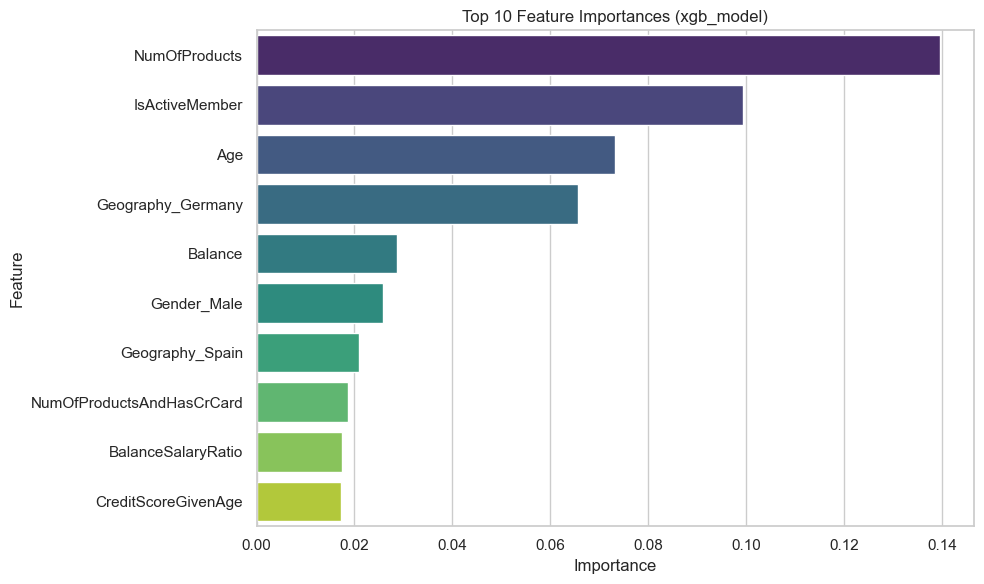

In [68]:
# Extract and visualize feature importances from the selected model

# Check if the best model supports feature importance extraction

best_model = xgb_model # Replace with the actual best model if needed
best_model_name = 'xgb_model'  # Replace with the actual best model name if needed


if hasattr(best_model, "feature_importances_"):
    # Extract feature importances
    feature_importances = best_model.feature_importances_
    feature_names = X.columns

    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)

    # Display the top 10 most important features
    print("\nTop 10 Most Important Features:")
    print(feature_importance_df.head(10))

    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x="Importance",
        y="Feature",
        data=feature_importance_df.head(10),
        palette="viridis"
    )
    plt.title(f"Top 10 Feature Importances ({best_model_name})")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
else:
    print(f"The selected model ({best_model_name}) does not support feature importance extraction.")

# Recommendations
Provide business recommendations based on the feature importances and EDA findings.

In [69]:
# Recommendations based on feature importances and EDA findings

# Extract the top features from the feature importance DataFrame
top_features = feature_importance_df.head(10)

# Generate recommendations based on the top features
recommendations = []

for feature in top_features["Feature"]:
    if feature == "CreditScore":
        recommendations.append("Focus on improving customer credit scores by offering financial literacy programs.")
    elif feature == "Age":
        recommendations.append("Target younger customers with tailored products to improve retention.")
    elif feature == "BalanceSalaryRatio":
        recommendations.append("Encourage customers with high balance-to-salary ratios to invest in premium products.")
    elif feature == "Tenure":
        recommendations.append("Reward long-tenured customers with loyalty programs to reduce churn.")
    elif feature == "NumOfProducts":
        recommendations.append("Promote cross-selling opportunities to customers with fewer products.")
    elif feature == "IsActiveMember":
        recommendations.append("Engage inactive members with personalized offers to increase activity.")
    elif feature == "EstimatedSalary":
        recommendations.append("Offer customized financial products based on customer salary levels.")
    elif feature == "HasCrCard":
        recommendations.append("Promote credit card usage benefits to customers without credit cards.")
    elif feature == "Geography_Germany":
        recommendations.append("Address specific needs of customers in Germany to improve satisfaction.")
    elif feature == "Geography_Spain":
        recommendations.append("Focus on customer retention strategies for the Spanish market.")

# Display the recommendations
print("\nBusiness Recommendations:")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")


Business Recommendations:
1. Promote cross-selling opportunities to customers with fewer products.
2. Engage inactive members with personalized offers to increase activity.
3. Target younger customers with tailored products to improve retention.
4. Address specific needs of customers in Germany to improve satisfaction.
5. Focus on customer retention strategies for the Spanish market.
6. Encourage customers with high balance-to-salary ratios to invest in premium products.


### Performance Comparison

In [70]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Evaluate the performance of each model on the training and testing datasets


# Define a function to evaluate models and return test metrics
def evaluate_model(name, y_train, y_train_pred, y_test, y_test_pred):
    test_metrics = {}
    test_metrics['Accuracy'] = accuracy_score(y_test, y_test_pred)
    test_metrics['Precision'] = precision_score(y_test, y_test_pred)
    test_metrics['Recall'] = recall_score(y_test, y_test_pred)
    test_metrics['F1 Score'] = f1_score(y_test, y_test_pred)
    test_metrics['ROC AUC'] = roc_auc_score(y_test, y_test_pred)
    return test_metrics

# Evaluate XGBoost model
xgb_metrics = evaluate_model("XGBoost", y_train, y_train_pred, y_test, y_test_pred)

# Evaluate Random Forest model
rf_metrics = evaluate_model("Random Forest", y_train, y_train_pred_rf, y_test, y_test_pred_rf)

# Evaluate LightGBM model
lgbm_metrics = evaluate_model("LightGBM", y_train, y_train_pred_lgb, y_test, y_test_pred_lgb)

# Evaluate Ensemble model
ensemble_metrics = evaluate_model("Ensemble", y_train, y_train_pred_ensemble, y_test, y_test_pred_ensemble)

# Create the DataFrame
performance_data = {
    'XGBoost': xgb_metrics,
    'Random Forest': rf_metrics,
    'LightGBM': lgbm_metrics,
    'Ensemble': ensemble_metrics
}

performance_df = pd.DataFrame(performance_data)

# Print the DataFrame
print(performance_df)

            XGBoost  Random Forest  LightGBM  Ensemble
Accuracy   0.858000       0.842500  0.869000  0.819500
Precision  0.718861       0.802632  0.798354  0.565714
Recall     0.496314       0.299754  0.476658  0.486486
F1 Score   0.587209       0.436494  0.596923  0.523118
ROC AUC    0.723361       0.640461  0.722949  0.695535
